In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt')
print(data.keys())

dict_keys(['Syy', 'Szz', 'S', 'w_grid', 'q_grid', 'params'])


In [3]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896839/checkpoints/epoch=2779-step=44480.ckpt'
    ).to(device)

In [4]:
prior_configs = {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}

particle = Particle(100, 2, prior_configs=prior_configs)
particle.positions.data[:,0] = data['params'][0]

In [5]:
raw_map_path = '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool'
memmap_mask_path='/pscratch/sd/z/zhantao/inxs_steering/mask_data'
grid_info = {
    'h_grid': [-3., 3., 90],
    'k_grid': [-3., 3., 90],
    'l_grid': [-15., 15., 60],
    'w_grid': [1., 200., 100]
}

psi_mask = PsiMask(raw_map_path, memmap_mask_path=memmap_mask_path,
                          grid_info=grid_info, device='cpu', preload=False)

obtained memmap mask name as: mask_h_-3.0_3.0_90_k_-3.0_3.0_90_l_-15.0_15.0_60_w_1.0_200.0_100.npy


In [6]:
# output_stack = []
var_calculator = OnlineVariance((np.prod(psi_mask.hkw_grid.shape[:-1]),1), device='cpu')
with torch.no_grad():
    for param in tqdm(particle.positions.T):
        input = psi_mask.get_model_input(param).to(device)
        output = model(input).view(-1, 1)
        var_calculator.update(output.detach().cpu())
        # output_stack.append(output.detach().cpu())

100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


In [7]:
std = var_calculator.std_dev().view(psi_mask.hkw_grid.shape[:-1])

In [8]:
std.shape

torch.Size([90, 90, 100])

In [9]:
utility = []
for _angle in tqdm(psi_mask.psi_grid):
    _mask = psi_mask.load_memmap_mask(_angle)
    utility.append((_mask.sum(dim=2) * std).mean())
    

100%|██████████| 360/360 [00:32<00:00, 11.21it/s]


In [10]:
utility = torch.stack(utility)

Text(0, 0.5, 'utility')

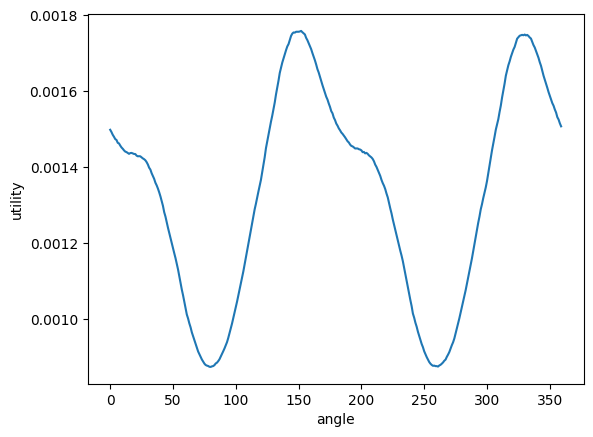

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(psi_mask.psi_grid, utility)
ax.set_xlabel('angle')
ax.set_ylabel('utility')

In [12]:
utility_diff = (utility - utility.min()) / (utility.max() - utility.min())

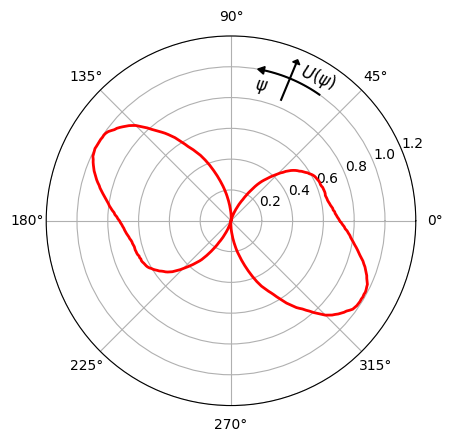

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Create a figure and an axis with a polar projection
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot data on the polar axis
ax.plot(psi_mask.psi_grid / 360 * 2 * np.pi, utility_diff, color='r', linewidth=2)

arc_arrow(ax, start_angle=55, end_angle=80, radius=utility_diff.max() * 1, arrow_size=0.025, label='$\psi$')

rad_arrow(ax, angle=135/2, start_radius=utility_diff.max() * 0.85, end_radius=utility_diff.max() * 1.15, arrow_size=0.025, label='$U(\psi)$')

ax.set_rlim([0, 1.2])

# Display the figure
plt.show()


In [14]:
from sklearn.model_selection import train_test_split

spec_dataset = SpectrumDataset(
    '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Aug01.pt',
    num_wq=50
    )

train_idx, val_test_idx = train_test_split(np.arange(len(spec_dataset)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)


In [15]:
idx_plot = 10
param_test = data['params'][train_idx[idx_plot]]

In [16]:
w_grid = data['w_grid']
q_grid = data['q_grid']
Syy_grid = data['Syy']
Szz_grid = data['Szz']

exp = SimulatedExperiment(q_grid, w_grid, Syy_grid[train_idx[idx_plot]], Szz_grid[train_idx[idx_plot]])

In [18]:
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz

In [19]:
measurement = calc_Sqw_from_Syy_Szz(psi_mask.hklw_grid, exp.Syy_func, exp.Szz_func)

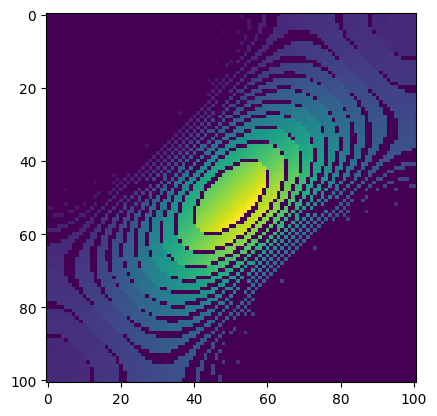

In [20]:
plt.imshow(Szz_grid[0,100].reshape(101,101))

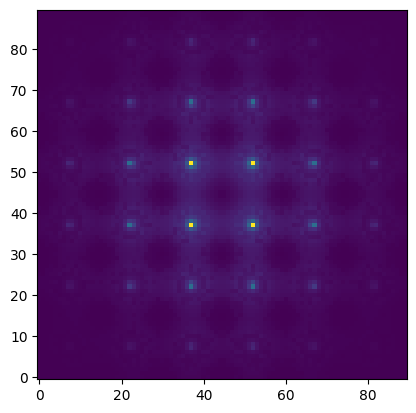

In [21]:
fig, ax = plt.subplots(1,1)
ax.imshow(measurement.sum(axis=-1).sum(axis=-1), origin='lower', aspect='auto')
ax.set_aspect('equal')

In [ ]:
# _mask = psi_mask.get_mask(1)

# dist_list = []
# model.to(device)
# with torch.no_grad():
#     for param in tqdm(particle.positions.T):
#         x, l = psi_mask.get_model_input(param, grid='hklw')
#         output = model(x[_mask].to(device), l[_mask].to(device)).cpu()
#         dist_list.append((output.squeeze() - measurement[_mask]).norm().item())

In [ ]:
model.to('cpu')
x, l = psi_mask.get_model_input(param_test, grid='hklw')
print(x[...,0].max())
_x = x[...,:3].clone().numpy()
print(x[...,0].max())
_x[...,:2] = np.abs(x.numpy()[...,:2] - np.round(x.numpy()[...,:2]))
print(x[...,0].max())
Syy_chck = torch.from_numpy(exp.Syy_func(_x))
Szz_chck = torch.from_numpy(exp.Szz_func(_x))

In [ ]:
xx = torch.cat(
    [
        torch.from_numpy(_x),
        torch.zeros(_x.shape[:-1] + (2,))
    ], dim=-1
)
xx = xx[...,0,0,:]
xx[...,-2:] = param_test
model.cpu()
with torch.no_grad():
    xx = model.prepare_input(xx)
    Syy_network = model.Syy_net(xx.cpu().to(model.dtype)).cpu()
    Szz_network = model.Szz_net(xx.cpu().to(model.dtype)).cpu()

In [ ]:
plt.imshow(Syy_chck[...,0,0])

In [ ]:
plt.imshow(Syy_network)

In [ ]:
with torch.no_grad():
    output_full = model(
        x[...,0,10,:].cpu(), 
        l[...,0,10,:].cpu(),
    ).cpu().reshape(input.shape[:2])
    # output_full = model(
    #     x[...,0,0,:].cpu(), 
    #     l[...,0,0,:].cpu(),
    #     Syy = Syy_chck[...,0,10],
    #     Szz = Szz_chck[...,0,10]
    # ).cpu().reshape(input.shape[:2])
    # output_chck = model.calculate_Sqw(torch.cat((x[...,:2], l, x[...,[2]]), dim=-1).view(-1,4), Syy_chck.view(-1), Szz_chck.view(-1)).view(x.shape[:-1])

In [ ]:
# model.calculate_Sqw(torch.cat((x[...,:2], l, x[...,[2]]), dim=-1).view(-1,4), Syy_chck.view(-1), Szz_chck.view(-1)).view(x.shape[:-1])

In [ ]:
# plt.imshow(calc_Sqw_from_Syy_Szz(psi_mask.hklw_grid[...,0,10,:], exp.Syy_func, exp.Szz_func))
# plt.imshow(calc_Sqw_from_Syy_Szz(torch.cat((x[...,0,10,:2], l[...,0,10,:], x[...,0,10,[2]]), dim=-1), exp.Syy_func, exp.Szz_func))

In [ ]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(output_full, origin='lower', aspect='auto')
# im = ax.imshow(output_chck[...,0,10], origin='lower', aspect='auto')
ax.set_aspect('equal')
fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(measurement[...,0,10], origin='lower', aspect='auto')
ax.set_aspect('equal')
fig.colorbar(im)

In [ ]:
from inxss import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.15,0.3],[0.5,0.5],[0,0]], 100))
wpts = spec_dataset.data_dict['w_grid']

x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
x[...,:3] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=-1)
x[...,3:] = param_test
print(x.detach().numpy()[-1,0,:3])
# x = model.prepare_input(x)
S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
print(x.detach().numpy()[-1,0,:3])

In [ ]:
S_true_func = RegularGridInterpolator(
    (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
    spec_dataset.data_dict['S'][train_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
S_true = S_true_func(x.detach().numpy()[...,:3])

# S_true = calc_Sqw_from_Syy_Szz(_x, exp.Syy_func, exp.Szz_func)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(S_true, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={param_test[0]:.2f}, \ J_{{p}}={param_test[1]:.2f}$')
fig.tight_layout()